In [19]:
!pip install ppscore

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
Dataset Info:
 None

Summary Statistics:
                 age        fnlwgt  education_num  c

<ipython-input-20-9e7f7cb941cd>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hours_per_week'] = hours_per_week_temp[outliers == 1].values



Predictive Power Score Matrix:
                   x                    y  ppscore
0               age                  age      1.0
238  hours_per_week  work_hours_category      1.0
64        education        education_num      1.0
83    education_num            education      1.0
84    education_num        education_num      1.0
105  marital_status       marital_status      1.0
126      occupation           occupation      1.0
147    relationship         relationship      1.0
168            race                 race      1.0
189    capital_gain         capital_gain      1.0


<ipython-input-20-9e7f7cb941cd>:87: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


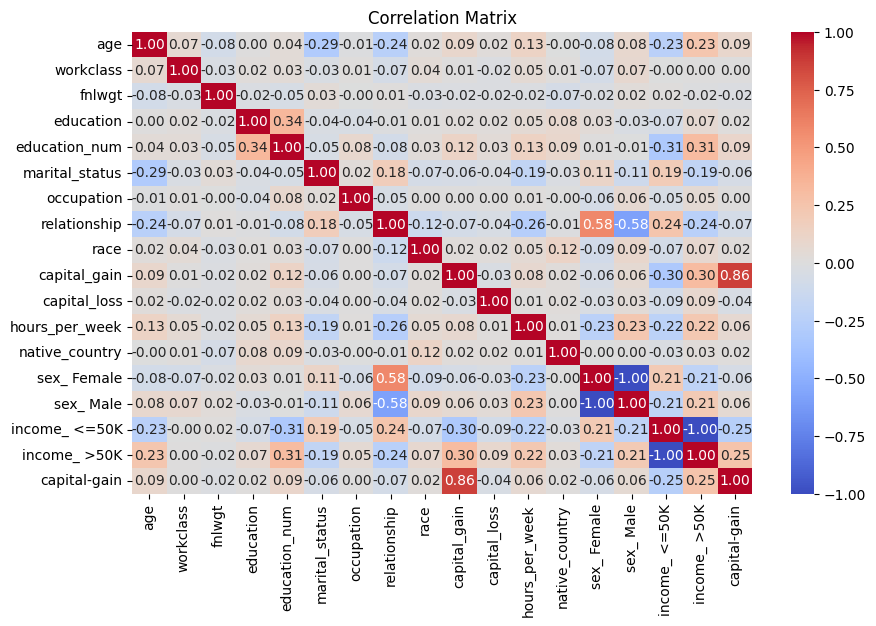

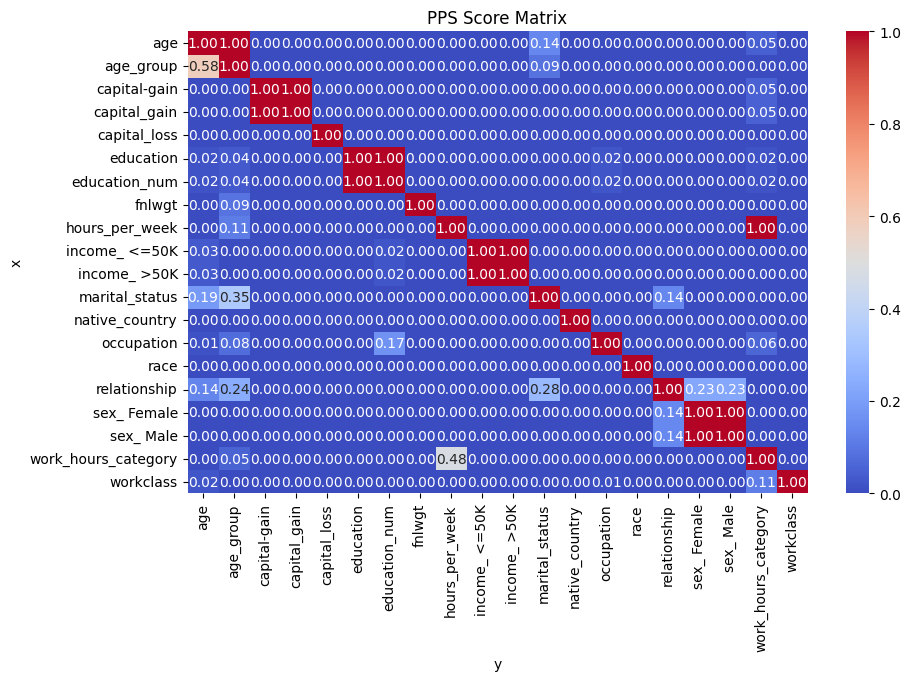


Final Processed Dataset Sample:
    age  workclass  fnlwgt  education  education_num  marital_status  \
0   39          5   77516          9             13               4   
1   50          4   83311          9             13               2   
2   38          2  215646         11              9               0   
3   53          2  234721          1              7               2   
4   28          2  338409          9             13               2   

   occupation  relationship  race  capital_gain  capital_loss  hours_per_week  \
0           0             1     4          2174             0              40   
1           3             0     4             0             0              13   
2           5             1     4             0             0              40   
3           5             0     2             0             0              40   
4           9             5     2             0             0              40   

   native_country  sex_ Female  sex_ Male  income_ <

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/adult_with_headers.csv")

# Clean column names to remove leading/trailing spaces
df.columns = df.columns.str.strip()

# Data Exploration
print("Dataset Info:\n", df.info())
print("\nSummary Statistics:\n", df.describe())
print("\nMissing Values:\n", df.isnull().sum())

# Handle missing values (imputation or removal)
for col in df.columns:  # Removing missing values for simplicity
  df[col]=df[col].replace(' ?',np.nan)
df.dropna(inplace=True)

# Apply Scaling to Numerical Features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

# Standard Scaling
standard_scaler = StandardScaler()
df_standard_scaled = df.copy()
df_standard_scaled[numerical_features] = standard_scaler.fit_transform(df[numerical_features])

# Min-Max Scaling
minmax_scaler = MinMaxScaler()
df_minmax_scaled = df.copy()
df_minmax_scaled[numerical_features] = minmax_scaler.fit_transform(df[numerical_features])

print("\nStandard Scaled Data Sample:\n", df_standard_scaled.head())
print("\nMin-Max Scaled Data Sample:\n", df_minmax_scaled.head())

# Encoding Techniques
categorical_features = df.select_dtypes(include=['object']).columns

# Identify features for label encoding
label_encoded_features = [col for col in categorical_features if df[col].nunique() >= 5]



# Apply One-Hot Encoding for categorical variables with < 5 categories
one_hot_encoded_features = [col for col in categorical_features if col not in label_encoded_features]
df = pd.get_dummies(df, columns=one_hot_encoded_features)

# Apply Label Encoding for categorical variables with > 5 categories
label_enc = LabelEncoder()
for col in label_encoded_features:
    df[col] = label_enc.fit_transform(df[col])

print("\nEncoded Data Sample:\n", df.head())

# Feature Engineering
# Creating new feature: Age group
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle-aged', 'Old'])

# Creating new feature: Work Hours Category
df['work_hours_category'] = pd.cut(df['hours_per_week'], bins=[0, 20, 40, 60, 100], labels=['Part-time', 'Full-time', 'Overtime', 'Extreme'])

print("\nFeature Engineering Sample:\n", df[['age', 'age_group', 'hours_per_week', 'work_hours_category']].head())

# Apply Log Transformation to a Skewed Feature
df['capital-gain'] = np.log1p(df['capital_gain'])  # log(1 + x) to handle zero values
print("\nLog Transformed Capital Gain:\n", df[['capital-gain']].head())

# Feature Selection
# Identify and Remove Outliers using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df[numerical_features])
hours_per_week_temp = df['hours_per_week'].copy()
df = df[outliers == 1]  # Keep only non-outliers

df['hours_per_week'] = hours_per_week_temp[outliers == 1].values

# Compute PPS Score
pps_matrix = pps.matrix(df)
print("\nPredictive Power Score Matrix:\n", pps_matrix[['x', 'y', 'ppscore']].sort_values(by='ppscore', ascending=False).head(10))

# Compare PPS with Correlation Matrix
correlation_matrix = df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(pps_matrix.pivot(index='x', columns='y', values='ppscore'), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("PPS Score Matrix")
plt.show()

print("\nFinal Processed Dataset Sample:\n", df.head())
